# Simulating Invasion

Studying the impact of multiphase conditions on transport in porous materials was the original motivation for pore network modeling. OpenPNM includes a set of algorithms for simulating drainage (i.e. non-wetting phase invasion) using both ordinary and invasion percolation. These will be covered in this notebook.

```{admonition} On simulating imbibition

  Imbibition is quite a bit more challenging to simulate than drainage, since the menisci movement mechanisms are more complicated. OpenPNM plans to offer some imbibition algorithms, but these need to be carefully developed so there are still 'works in progress'.
```

In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt
op.visualization.set_mpl_style()

Setup the necessary objects:

In [2]:
np.random.seed(5)
pn = op.network.Demo(shape=[25, 25, 1], spacing=1e-4)
air = op.phase.Air(network=pn)

The `air` phase created above need some physics model that relates fluid properties like surface tension and contact angle, to geometric properties such pore and throat diameter.  Let's assume that water is the wetting phase, and air is non-wetting, with a contact angle of 120 degrees, and let's also use the Washburn equation to compute the capillary entry pressure.

In [3]:
air['pore.contact_angle'] = 120
air['pore.surface_tension'] = 0.072
f = op.models.physics.capillary_pressure.washburn
air.add_model(propname='throat.entry_pressure',
              model=f, 
              surface_tension='throat.surface_tension',
              contact_angle='throat.contact_angle',
              diameter='throat.diameter',)

## Drainage

Drainage refers to the process of a non-wetting fluid displacing a wetting fluid, by application of increasingly high capillary pressures where $ P_c = P_{nwp} - P_{wp} $.  Thus, either the non-wetting phase pressure can be increased, or the wetting phase pressure can be decreased (i.e. suction).  The term "drainage" stems from the process of *draining* water from a sand column, where water is the wetting phase and air is non-wetting, so "draining" water is actually invasion of air. The term drainage is now used for any case regardless of which fluids are involved. When it is not clear which fluid is wetting or not, it is best to use the terms *injection* and *withdrawal* to avoid confusion.

### Manual Implementation of the Drainage Process

Before outlining the `Drainage` algorithm in OpenPNM, let's illustrate the process by hand. This requires the following steps:

1. Identify all the throats that can be invaded at a given applied capillary pressure
2. Use `scipy.sparse.csgraph.connected_components` to label each cluster
3. Trim clusters that are not connected to the inlets

In [4]:
from scipy.sparse import csgraph as csg
Pc = air['throat.entry_pressure'].mean()
Ts = 1.0*(air['throat.entry_pressure'] < 0.8*Pc)
am = pn.create_adjacency_matrix(weights=Ts, fmt='csr', triu=False, drop_zeros=True)
clusters = csg.connected_components(am, directed=False)[1]
print(clusters)

[  0   1   2   3   3   3   3   3   4   5   6   3   3   7   3   8   9  10
  11  11  11  12  13  14  15  16  17   3   3  18  19  20   3   3  21   3
  22   3   3   3  23  11  11  11  24  11  11  25  26  26  27  27  28  29
  30  31   3   3   3   3   3   3   3   3   3  32  33  34  11  11  35  36
  37  38  26  39  27  27  27  27  27  40   3  41  42  43   3   3  44  45
  11  46  11  11  11  11  11  47  11  48  27  27  49  50  27  27  51  52
  53  53  54   3  55  56  11  11  11  11  11  11  11  11  11  11  57  58
  59  60  61  27  62  63  63  64  65  66  67  11  68  69  11  11  11  11
  70  11  11  71  11  11  72  73  27  27  27  74  75  63  76  11  11  77
  11  11  11  11  11  78  11  11  11  11  79  80  81  82  83  27  27  84
  85  86  87  88  11  11  11  11  11  11  11  11  11  11  89  11  11  90
  91  92  93  94  95  96  97  98  11  11  11  99  11  11  11  11  11 100
  11  11  11 101 102  11  11  11  11 103 104 105 106 107 108  11 109  11
  11  11  11  11 110  11 111  11 112  11 113 114  1

The `clusters` array is a list of which cluster number each node (i.e. pore) belongs to. We can see this more clearly by plotting the pores and coloring by their cluster number:

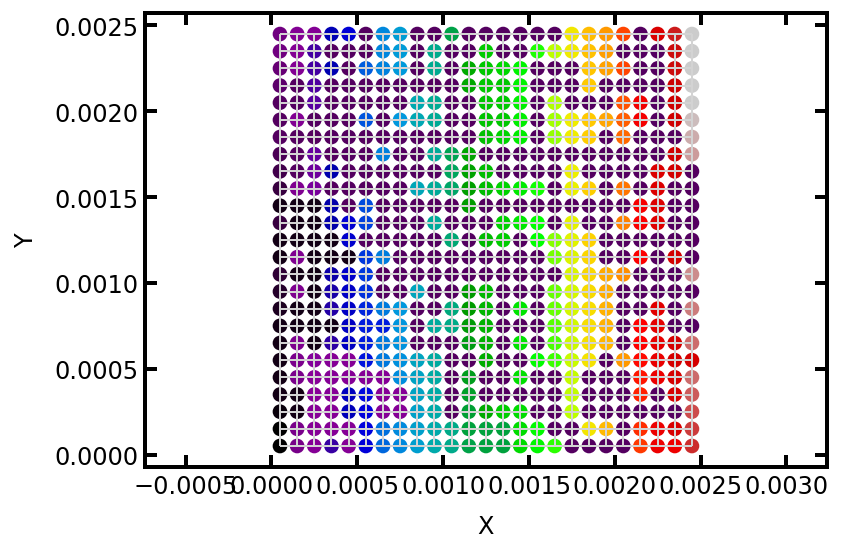

In [5]:
ax = op.visualization.plot_coordinates(network=pn, color_by=clusters, s=40, cmap=plt.cm.nipy_spectral)
ax = op.visualization.plot_connections(network=pn, c='lightgrey', ax=ax);

The 'black' cluster extends from the left edge throughout the domain, while the other colors are not connected to the left edge.  Physically speaking only pores that are connected to the left edge can be filled, so all the other cluster numbers should be set to uninvaded. This is illustrated in the following block where the yellow pores are invaded:

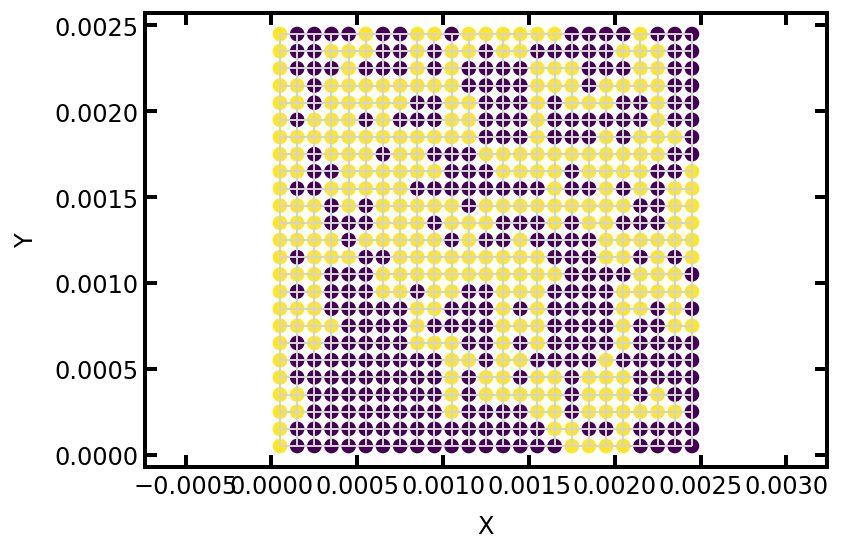

In [6]:
invaded_pores = np.isin(clusters, clusters[pn.pores('left')])
ax = op.visualization.plot_coordinates(network=pn, color_by=invaded_pores, s=40, cmap=plt.cm.viridis)
ax = op.visualization.plot_connections(network=pn, c='lightgrey', ax=ax);

The above process can yield a capillary pressure or drainage curve be repeating for increasingly high values of 'throat.entry_pressure' until the entire domain is invaded. This is the process that is used in the `Drainage` algorithm.

### Using the `Drainage` Algorithm

To simulate drainage in OpenPNM, we must create a `Drainage` object, which requires specifying the non-wetting, or invading phase. The invading phase object (`air`) contains the information about the capillary pressure required for it to invade a throat (and subsequently the pore beyond it). We also must tell the algorithm where the invasion starts from.  Finally we can run it:

In [7]:
drn = op.algorithms.Drainage(network=pn, phase=air)
drn.set_inlet_BC(pores=pn.pores('left'))
drn.run()

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

The result of running the algorithm is that several new arrays are added to the `drn` object. Specifically, there are arrays containing the pressure at which each pore and throat was invaded, as well as the sequence.  

In [8]:
print(drn)


══════════════════════════════════════════════════════════════════════════════
drainage_01 : <openpnm.algorithms.Drainage at 0x1da07ff6770>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.invasion_pressure                                          625 / 625
  3  throat.invasion_pressure                                      1200 / 1200
  4  pore.invasion_sequence                                          625 / 625
  5  throat.invasion_sequence                                      1200 / 1200
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.all                                                        

The `'invasion_pressure'` and `'invasion_sequence'` arrays are quite useful because the actually contain the entire invasion history in a single array.  We can obtain the invasion pattern at any applied pressure by doing:

In [9]:
inv_pattern = drn['throat.invasion_pressure'] < 9000

Now we can plot only the invaded throats:

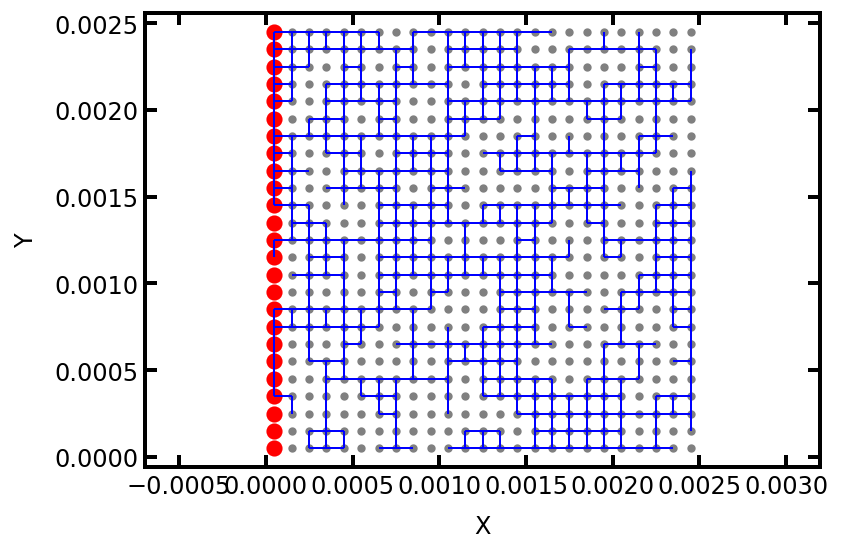

In [10]:
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

We can also apply trapping, which is done as a post processing step. This requires first specifying the outlet pores through which the wetting phase can escape, then running the `apply_trapping` method, which alters the `'invasion_pressure'` and `'invasion_sequence'` arrays. It sets `'invasion_pressure'` and `'invasion_sequence'` to `inf` to indicated trapped by pores/throats, so that they are not found when doing `drn['throat.invasion_pressure'] < p`. 

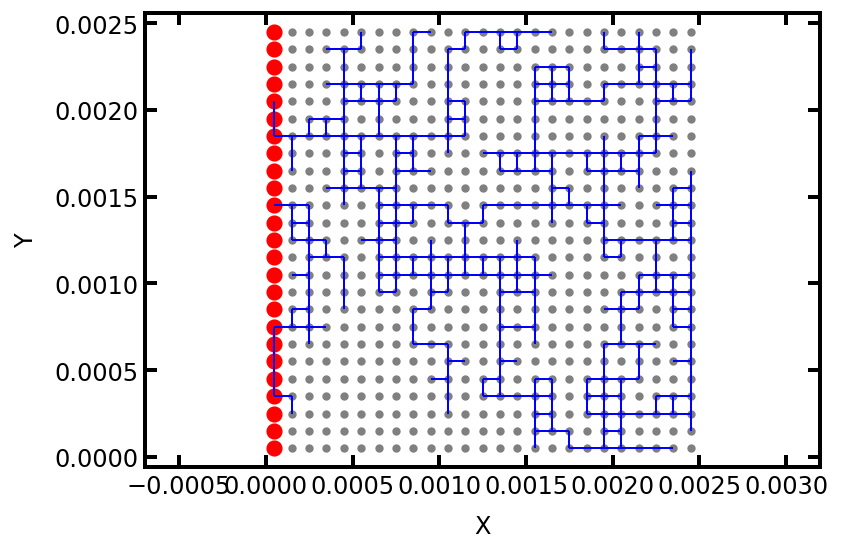

In [11]:
drn.set_outlet_BC(pores=pn.pores('right'), mode='overwrite')
drn.apply_trapping()
inv_pattern = drn['throat.invasion_pressure'] < 9000
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

One of the main uses of the `Drainage` algorithm is to simulate capillary pressure curves, and specifically mercury intrusion porosimetry. One of the main ways to calibrate a PNM is to ensure that the simulated MIP curve matches experimental data. Let's simulate this:

In [12]:
pn = op.network.Demo(shape=[20, 20, 1], spacing=1e-4)
hg = op.phase.Mercury(network=pn)
f = op.models.physics.capillary_pressure.washburn
hg.add_model(propname='throat.entry_pressure',
             model=f, 
             surface_tension='throat.surface_tension',
             contact_angle='throat.contact_angle',
             diameter='throat.diameter',)
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))  # mercury invades from all sides
mip.run()

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

The `Drainage` class has a `pc_curve` method, which returns a [namedtuple](https://stackoverflow.com/questions/2970608/what-are-named-tuples-in-python) with `pc` and `snwp` data attributes that can be directly plotted:

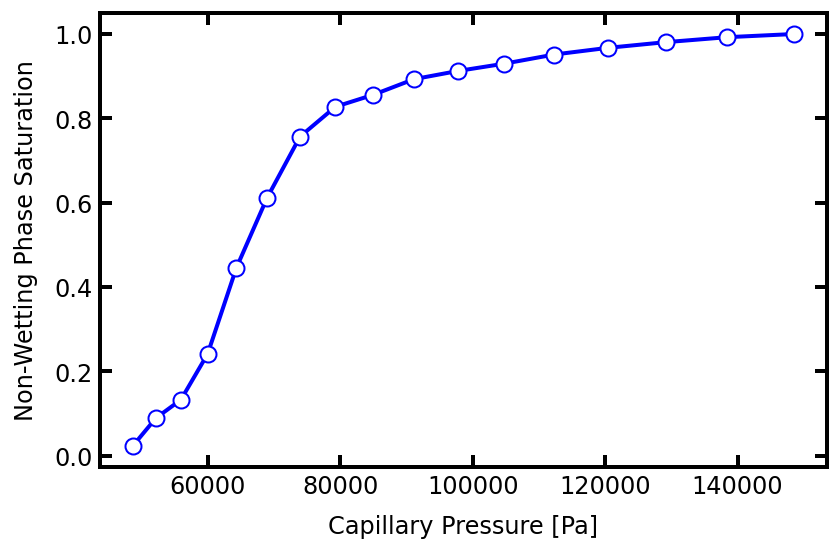

In [13]:
data = mip.pc_curve()
plt.plot(data.pc, data.snwp, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation');

Trapping does not occur in an MIP experiment since the wetting phase (air) is evacuated prior to mercury injection, but we can still apply trapping to the simulations just for demonstration purposes:

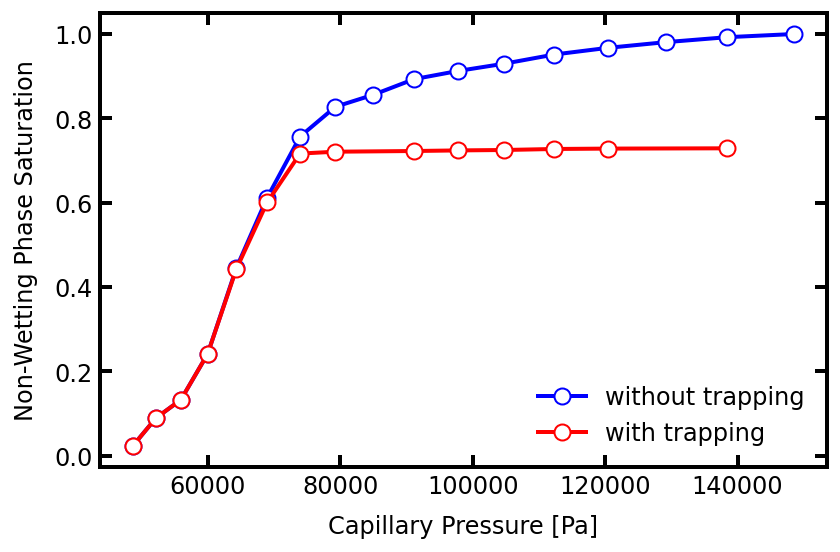

In [14]:
mip.set_outlet_BC(pores=pn.pores('right'), mode='overwrite')
mip.apply_trapping()
data2 = mip.pc_curve()
plt.plot(data.pc, data.snwp, 'b-o', label='without trapping')
plt.plot(data2.pc, data2.snwp, 'r-o', label='with trapping')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation')
plt.legend();

The impact of trapping is that the non-wetting phase saturations does not reach 1.0, but plateaus at some lower value. 

```{warning} 
 **Inlet pores start invaded**
  The curve shown above starts at a non-wetting phase saturation slightly above 0.  This is because the inlet pores are set to invaded to begin the algorithm. If the domain is large this is not really noticeable. To be fully rigorous, one should actually add "boundary pores" to the domain, which are fictitious pores that have no volume. Another solution is to set the pore volume of the inlet pores to 0, with `pn['pore.volume@left'] = 0`.
```

## Invasion Percolation
Invasion percolation is performed by invading individual throats based on the next most easily invadedable option, rather than applying a fixed pressure like the drainage algorithm does (which is based on ordinary percolation, with access limitations). IP therefore provides a lot more information since each individual invasion event is tracked. IP can be thought of as a volume-controlled injection where drainage is a pressure-based process.  In other words, in drainage the pressure is increased in steps and all invaded locations are found.  In invasion percolation, some incremental amount of volume is injected, corresponding to the volume required to invaded the next available throat and the pore beyond it.

### Manual Implementation of the Invasion Percolation Process

Invasion percolation is more computationally involved than drainage, mainly because there is not a dedicated function for this in `scipy.sparse.csgraph`. OpenPNM uses a [binary heap](https://en.wikipedia.org/wiki/Binary_heap), which is available in python's standard library. It is a `list` where the elements are sorted in special way, such that the first element always has the smallest value, which is convenient if the list is sorted by 'throat.entry_pressure'. It is then trivial to determine which throat should be invaded next.  The process works by the following steps:

1. Identify the next most easily invadable throat
2. Set this throat to invaded and remove it from the queue
3. Identify which pore is now accessible via this newly invaded throat
4. If it is not already invaded then:
  1. Set it to invaded
  2. Find all of its neighboring throats and add them to the queue
5. Return to step 1 and repeat

In [213]:
np.random.seed(5)
pn = op.network.Demo(shape=[20, 20, 1], spacing=1e-4)
air = op.phase.Air(network=pn)
air['pore.contact_angle'] = 120
air['pore.surface_tension'] = 0.072
f = op.models.physics.capillary_pressure.washburn
air.add_model(propname='throat.entry_pressure',
              model=f, 
              surface_tension='throat.surface_tension',
              contact_angle='throat.contact_angle',
              diameter='throat.diameter',)

Let's start by invading from pore 1, which has 3 throats:

In [214]:
Pinv = np.zeros(pn.Np, dtype=bool)  # Pre-allocate array for storing pore invasion state
Tinv = np.zeros(pn.Nt, dtype=bool)  # Pre-allocate array for storing throat invasion state
Pinv[1] = True
Ts = pn.find_neighbor_throats(pores=[1])
q = [(air['throat.entry_pressure'][i], i) for i in Ts]
print(q)

[(9260.551831957264, 0), (9493.684102948077, 1), (8650.998219036306, 381)]


Note that we use a `tuple` containing the entry pressure and the throat index. The queue will be sorted by the first element of the `tuple`, and we can use the 2nd element to know which actual throat should be set to invaded. The first step is to convert `q` into a heap:

In [215]:
import heapq as hq
hq.heapify(q)
print(q)

[(8650.998219036306, 381), (9493.684102948077, 1), (9260.551831957264, 0)]


Printing the queue shows that the first element is indeed the most easily invaded one. Note that the rest of the elements are NOT in sequential order but are in a special order dictated by the `binary heap` data structure. We only care about the first entry. We can 'invade' this throat by "popping" the first entry off the queue using `heappop`:

In [216]:
T = hq.heappop(q)
print(T)

(8650.998219036306, 381)


Now we can (a) set this throat to invaded in the `Tinv` list and (b) find the newly invaded pore and add its throats to the queue (if they are not already invaded OR on the queue already):

In [217]:
Tinv[T[1]] = True
P_new = pn.conns[T[1]]
print(P_new)

[ 1 21]


Now we must reduce this to a list of pores that are not already invaded:

In [218]:
P_next = P_new[~Pinv[P_new]]
print(P_next)

[21]


Noting that pore [1] was our starting pore, this is correct.  Now let's set [21] to invaded:

In [219]:
Pinv[P_next] = True

Now we find all the neighboring throats of this pore and add them to the queue...if they are not already invaded.

In [220]:
T_new = pn.find_neighbor_throats(pores=P_next)
T_next = T_new[~Tinv[T_new]]
print(T_next)

[ 19  20 401]


```{note}

  We should probably ensure that these throat are not already in the queue, which could be done by creating another array similar to `Tinv` which tracks this; however, inserting them into the queue will not break anything, it just means that we will waste time handling throats that are already invaded. In the code below we'll add a check to pop any duplicate throats off the list.
```

These throats should be added to the queue.  The power of the `heap` data structure is that the sorting of the list is maintained when new elements are added. This is accomplished as follows:

In [221]:
for i in T_next:
    hq.heappush(q, (air['throat.entry_pressure'][i], i))
print(q)

[(8650.998219036306, 19), (8650.998219036306, 20), (9260.551831957264, 0), (9493.684102948077, 1), (8650.998219036306, 401)]


We can see that the new throats have been added to the queue. We can also confirm that the entry in the first element of the queue has the lowest entry pressure. The above steps can be repeated in a for-loop as follows: 

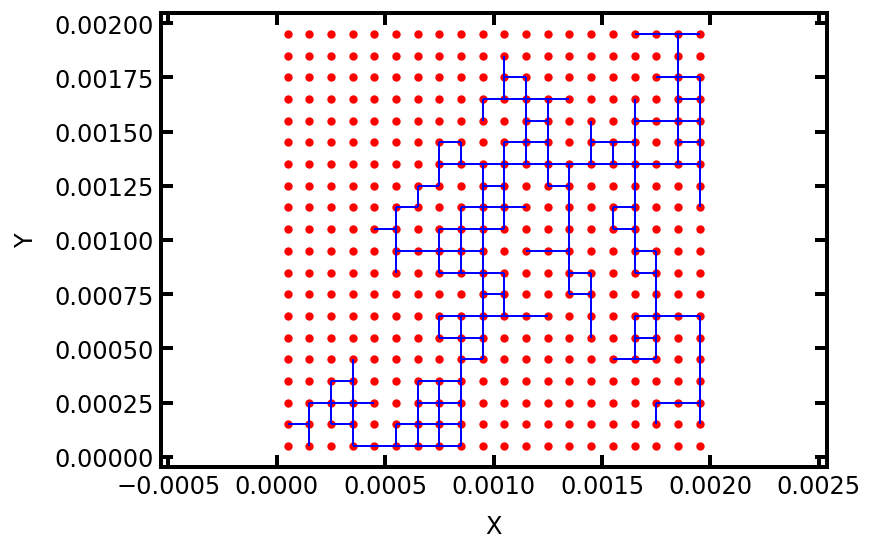

In [222]:
for _ in range(199):
    T = hq.heappop(q)
    # If next throat in q is the same index, pop until it's not
    while q[0][1] == T[1]:
        # print(f"popping duplicate throat {T[1]}")
        hq.heappop(q)
    Tinv[T[1]] = True
    P_new = pn.find_connected_pores(throats=T[1], flatten=True)
    P_next = P_new[~Pinv[P_new]]
    Pinv[P_next] = True
    T_new = pn.find_neighbor_throats(pores=P_next)
    T_next = T_new[~Tinv[T_new]]
    for i in T_next:
        hq.heappush(q, (air['throat.entry_pressure'][i], i))
ax = op.visualization.plot_connections(network=pn, throats=Tinv)
ax = op.visualization.plot_coordinates(network=pn, ax=ax);

```{note} **A note about computational performance**

  The OpenPNM implementation uses 'just-in-time' compilation offer by the `numba` package to accelerate the for-loop so the process demonstrated above is actually quite fast
```

### Using the `InvasionPercolation` Algorithm

In [208]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
pn['pore.volume'][1] = 0.0
ip.set_inlet_BC(pores=[1])
np.random.seed(5)
ip.run()

Like drainage, the `'pore.invasion_sequence'` and `'throat.invasion_sequence'` are added to the algorithm dictionary after calling `run`.  This enables a similar plotting of invasion patterns:

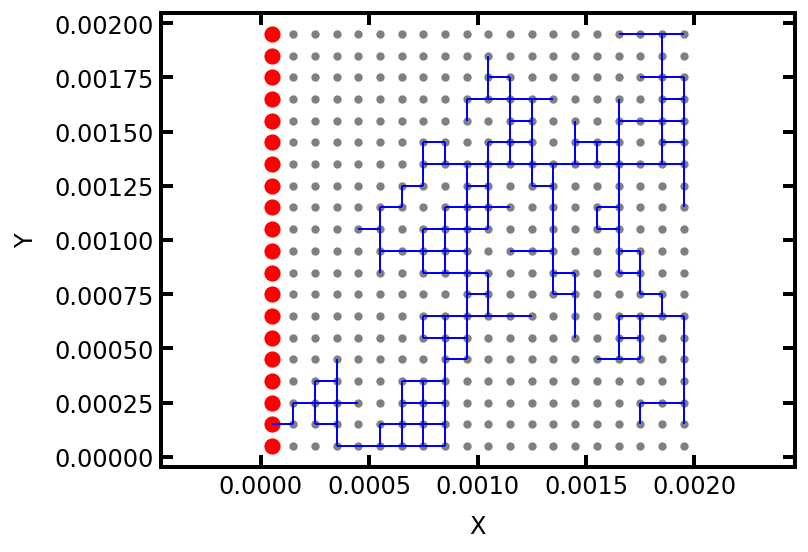

In [209]:
inv_pattern = ip['throat.invasion_sequence'] <= 200
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

We can also apply trapping as a post processing step.  Like the `Drainage` algorithm, this sets the invasion sequence number for any trapped pores to `inf` so that invasion patterns can be found using boolean query (e.g. < N).

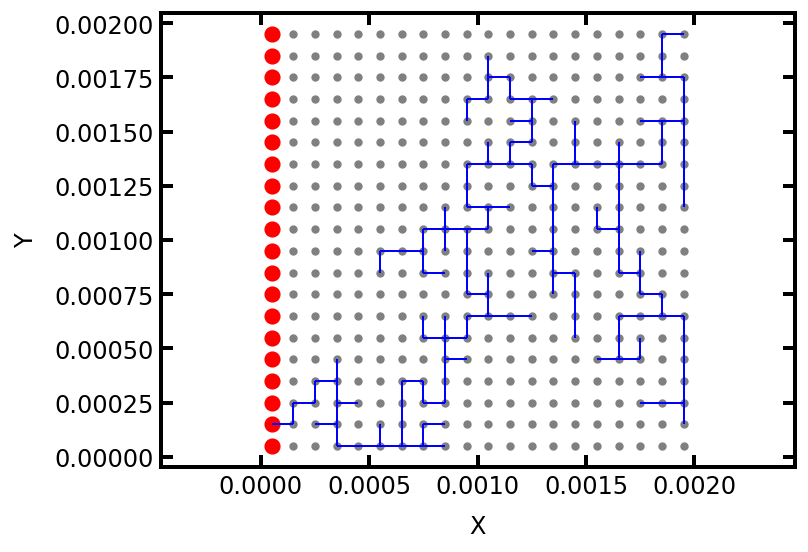

In [206]:
ip.set_outlet_BC(pn.pores('right'), mode='overwrite')
ip.reset()
ip.run()
ip.apply_trapping()
inv_pattern = (ip['throat.invasion_sequence'] < 200)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

```{note} **Invasion sequence is not contiguous after trapping**

  When `ip.run()` is called the invasion sequence is a contiguous series of numbers from 0 to Nt; however, after trapping is applied the invasion sequence of trapped throats/pores is set to `inf` while the untrapped throats/pores retain their original numbers. 

```

Because IP is a volume-based approach, the actually applied pressure varies up and down depending on the size of the throat being invaded.  The `ip` algorithm also has a `pc_curve` function, which computes the capillary pressure at each saturation and outputs data similar to the drainage algorithm. In fact, it is quite interesting to overlay these curves:

Performing drainage simulation:   0%|          | 0/25 [00:00<?, ?it/s]

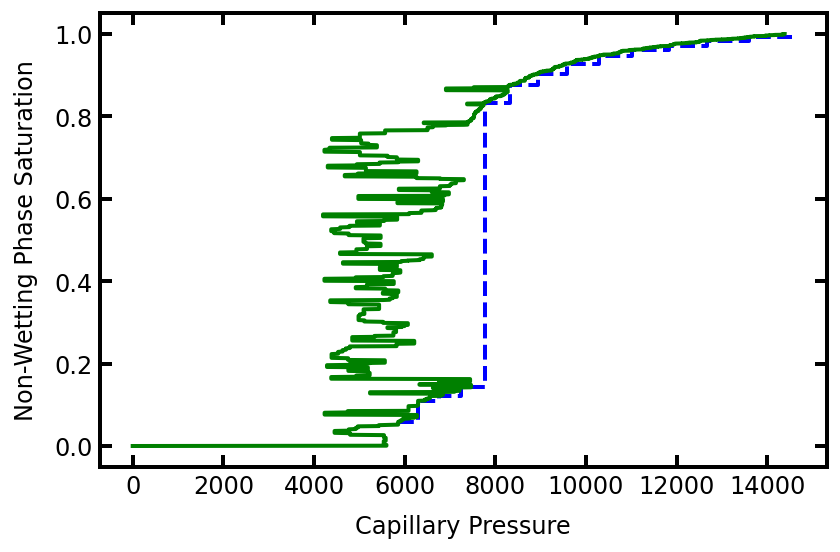

In [207]:
pn['pore.volume@left'] = 0.0

drn = op.algorithms.Drainage(network=pn, phase=air)
drn.set_inlet_BC(pores=pn.pores('left'))
drn.run()
data = drn.pc_curve()

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
ip.set_inlet_BC(pores=pn.pores('left'))
ip.run()
data_ip = ip.pc_curve()
plt.step(data.pc, data.snwp, 'b--', where='post')
plt.plot(data_ip.pc, data_ip.snwp, c='green')
plt.xlabel('Capillary Pressure')
plt.ylabel('Non-Wetting Phase Saturation');

In the above cell we first set the volume of the inlet pores to 0, this ensures that both algorithms start with 0 invaded volume. Next we run both the algorithms with the 'left' pores as inlets, and neglect trapping, which assumes that the wetting phase remains connected via small films in corners and cracks. Plotting these results together reveals a few things.  

1. The drainage curve is plotted as steps, where each jump in saturation is caused by application of a higher pressure step. 
2. The invasion percolation curve displays the rising and falling capillary pressure indicating that after a small throat is invaded (a spike) a series of larger throats a then accessed (the valleys).  
3. The invasion percolation curve never exceeds the drainage curve and in fact the drainage curve represents the envelop of peak pressures observed by the invasion percolation process.